# I. Lý thuyết

1) Trong thuật toán YOLO thì biến mục tiêu bao gồm những thành phần nào ?

Đáp án:

A. Điểm xác suất tồn tại object, bounding box, phân phối xác suất classes. Trường hợp không tồn tại object thì các thành phần khác bỏ trống.


2) Điều gì khiến cho việc dự báo bounding box trong YOLOv2 ổn định hơn so với trước đó?
Bạn có thể tham khảo thêm tổng hợp các cải tiến của [YOLOv2](https://www.geeksforgeeks.org/yolo-v2-object-detection/)

Đáp án:

B. Coordinator gốc (x, y ,w, h)  được chuyển sang các tham số transformed tương ứng là (tx, ty, tw, th) theo hàm sigmoid và exponential nên ổn định hơn. 


 
3) Ý tưởng chính của các thuật toán Keypoint Object Detection là gì?

Đáp án:

C. Sử dụng bản đồ heatmap để tìm ra các keypoints mà những keypoints này giúp định hình bounding boxes.


4) Trong thuật toán CenterNet, khi nào chúng ta sẽ loại bỏ một Bounding box dự báo ?
Đáp án:

D. Khi điểm center point nằm bên ngoài vùng central region là một ô vuông trung tâm được xác định bởi hai điểm Top-left và Bottom-down.


5) Để ghép cặp các điểm Top-left và Bottom-down về cùng một Object trong thuật toán CenterNet chúng ta sẽ tìm ra biểu diễn Embedding vector để so khớp chúng. Những biểu diễn này được huấn luyện trên hàm Loss function như thế nào ?

Đáp án:

A. Một hàm loss distance để đẩy hai điểm cách xa nếu khác object và hàm loss similarity để kéo hai kiểm lại gần nếu cùng object.


6) Thuật toán DETR (detection with transformers) có gì nổi bật ?

Đáp án:

B. Lần đầu sử dụng kiến trúc Transformers Encoder Decoder để dự báo một set predictions và sử dụng phương pháp Hungarian Optimization để matching và huấn luyện bounding boxes.



# II. Thực hành

[Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection) là cuộc thi object detection trong nông nghiệp nhằm phát hiện đối tượng là các đầu bông lúa từ ảnh đầu vào của các giống lúa, điều kiện trưởng thành, màu sắc, hướng đầu, điều kiện thời tiết và sinh trưởng. Bạn được cung cấp hơn 3000 ảnh huấn luyện có nhãn từ Châu Âu, Canada và testing trên 1000 ảnh từ Úc, Nhật và Trung Quốc.

Hãy thực hành huấn luyện lại các thuật toán cho cuộc thi này bao gồm:

7) YOLO

8) CenterNet

9) DETR

Gợi ý: bạn có thể tham khảo từ các notebooks trên kaggle hoặc từ các github resources liên quan tới thuật toán.

10) Hãy đề xuất đề tài nghiên cứu cho project cuối khóa. Phác thảo các bước cần triển khai trong nghiên cứu đó bao gồm: nội dung, timeline ước tính và kết quả.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/DL/8.Homework_HauTran")

##7) YOLO

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 11413, done.
remote: Total 11413 (delta 0), reused 0 (delta 0), pack-reused 11413
Receiving objects: 100% (11413/11413), 11.24 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (7886/7886), done.


In [ ]:
!pip install -U -r yolov5/requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import os
df = pd.read_csv('../data/global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x1'] = df['x'] + df['w']
df['y1'] = df['y'] + df['h']
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x1','y1','classes']]
df.head()

In [ ]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
index = f7(df.image_id)
import random
random.Random(42).shuffle(index)
len(index)

In [ ]:
source = 'train'
for fold in [0]:
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    for name,mini in tqdm(df.groupby('image_id')):
        if not os.path.exists('convertor'):
            os.makedirs('convertor')
        sh.copy("../data/global-wheat-detection/{}/{}.jpg".format(source,name),'convertor/{}.jpg'.format(name))
        if name in val_index:
            path2save = 'convertor/val.txt'
        else:
            path2save = 'convertor/train.txt'
        with open(path2save, 'a') as f:
            f.write(f'{name}.jpg')
            row = mini[['x','y','x1','y1','classes']].astype(int).values
            # row = row/1024
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '+','.join(row[j])
                f.write(text)
            f.write('\n')

##8) CenterNet

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision

In [ ]:
# Hyper-params
MODEL_PATH = ""
input_size = 512
IN_SCALE = 1024//input_size 
MODEL_SCALE = 4
batch_size = 2
model_name = "resnet18"
TRAIN = True # True for training

In [ ]:
DIR_INPUT = '../data/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWa

In [ ]:
# Split train-test
from sklearn.model_selection import train_test_split
# Split by unique image ids.
image_ids = train_df['image_id'].unique()
train_id, test_id = train_test_split(image_ids, test_size=0.2, random_state=777)

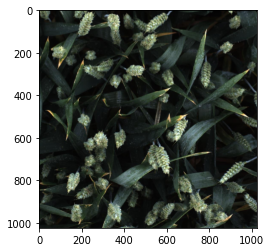

In [ ]:
# show image
img_id = train_id[0]
img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id+".jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# get targets
target = train_df[train_df['image_id']==img_id]
# convert targets to its center.
try:
    center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2]).T
except:
    center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2)]).T.reshape(1,2)

In [ ]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

In [ ]:
# Wrapped heatmap function
def make_hm_regr(target):
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    
    if len(target) == 0:
        return hm, regr
    
    try:
        center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2, 
                       target["w"], target["h"]
                      ]).T
    except:
        center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2), 
                       int(target["w"]), int(target["h"])
                      ]).T.reshape(1,4)
    
    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE, int(c[1])//MODEL_SCALE//IN_SCALE], 
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))    

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i, 
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;
    return hm, regr

In [ ]:
def pred2box(hm, regr, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    # get regressions
    pred_r = regr[:,pred].T

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    for i, b in enumerate(pred_r):
        arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2, 
                      int(b[0]*input_size), int(b[1]*input_size)])
        arr = np.clip(arr, 0, input_size)
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [ ]:
# functions for plotting results
def showbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("preds:",boxes.shape)
    sample = img

    for box in boxes:
        # upper-left, lower-right
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (220, 0, 0), 3)
    return sample

def showgtbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("GT boxes:", boxes.shape)
    sample = img

    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (0, 220, 0), 3)
    return sample

preds: (70, 4)


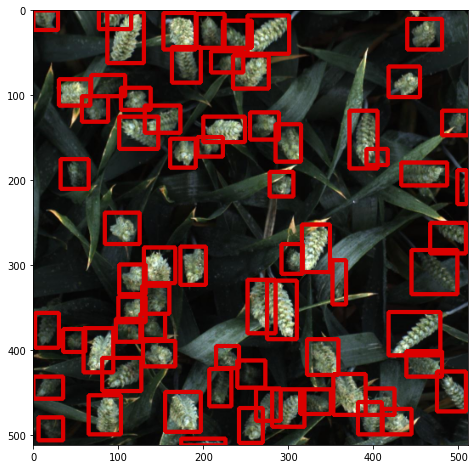

In [ ]:
# show image
#img_id = train_df["image_id"][]
img_id = train_id[0]
img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id+".jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (input_size, input_size))
sample = img

# get labels
target = train_df[train_df['image_id']==img_id]

# convert target to heatmaps
hm, regr = make_hm_regr(target)

# get boxes
boxes, _ = pred2box(hm, regr)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sample = showbox(sample, hm, regr, 0.99)
plt.imshow(sample)
plt.show()

In [ ]:
from torchvision import transforms

class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    
# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))            
            for c1 in range(3):
                for c2 in range(3):
                    #print(c1,c2)
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(DIR_INPUT,"train", self.img_id[idx]+".jpg"))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image_id']==self.img_id[idx]]
        hm, regr = make_hm_regr(target)
        return img, hm, regr

# Submission
class WheatDatasetTest(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.img_id = os.listdir(self.image_dir)
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.image_dir, self.img_id[idx]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        return img, self.img_id[idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


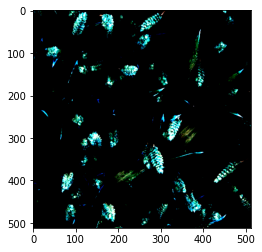

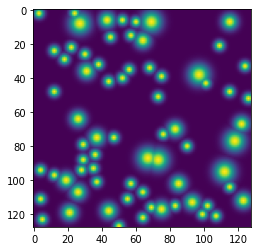

In [ ]:
traindataset = WheatDataset(train_id, train_df)
valdataset = WheatDataset(test_id, train_df)
testdataset = WheatDatasetTest('../data/global-wheat-detection/test')

# Test dataset
img, hm, regr = traindataset[0]
plt.imshow(img.transpose([1,2,0]))
plt.show()
img.std()
plt.imshow(hm)

In [ ]:
# Pack to dataloaders
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False, num_workers=0)

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()
        # create backbone.
        basemodel = torchvision.models.resnet18(pretrained=False) # turn this on for training
        basemodel = nn.Sequential(*list(basemodel.children())[:-2])
        # set basemodel
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [ ]:
model = centernet()
# Check if it runs correctly
model(torch.rand(1,3,512,512))[0].size()

torch.Size([1, 1, 128, 128])

In [ ]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# From centernet repo
def neg_loss(pred, gt):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
  '''
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  
def centerloss(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = neg_loss(pred_mask, mask)
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [ ]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    for idx, (img, hm, regr) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        regr_gt = regr.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        hm, regr = model(img)
        preds = torch.cat((hm, regr), 1)
            
        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)
        # misc
        running_loss += loss
        running_mask += mask_loss
        running_regr += regr_loss
        
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})')
        
    #scheduler.step()
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('maskloss : {:.4f}'.format(running_mask/(len(train_loader))))
    print('regrloss : {:.4f}'.format(running_regr/(len(train_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'loss': running_loss/len(train_loader), "mask": running_mask/(len(train_loader)), 
                 "regr": running_regr/(len(train_loader))}
    logs.append(log_epoch)

In [ ]:
#epochs=100
epochs = 5
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

epochs 1/5 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/1349 [00:00<?, ?it/s]

train loss : 1.6624
maskloss : 1.5781
regrloss : 0.0843
epochs 2/5 


  0%|          | 0/1349 [00:00<?, ?it/s]

train loss : 0.8755
maskloss : 0.8115
regrloss : 0.0640
epochs 3/5 


  0%|          | 0/1349 [00:00<?, ?it/s]

train loss : 0.7758
maskloss : 0.7162
regrloss : 0.0596
epochs 4/5 


  0%|          | 0/1349 [00:00<?, ?it/s]

train loss : 0.6560
maskloss : 0.6001
regrloss : 0.0559
epochs 5/5 


  0%|          | 0/1349 [00:00<?, ?it/s]

train loss : 0.5131
maskloss : 0.4620
regrloss : 0.0511


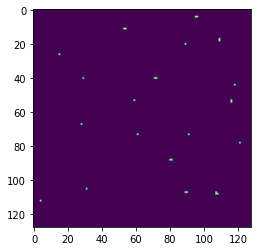

preds: (28, 4)
GT boxes: (51, 4)


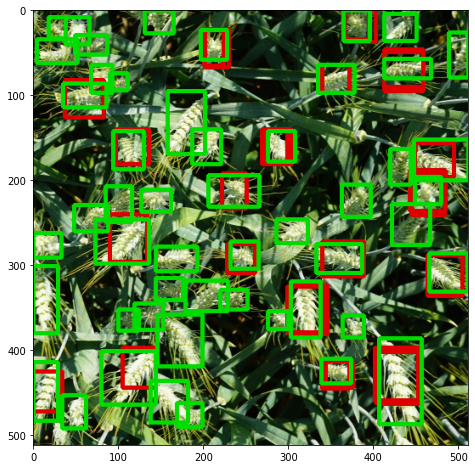

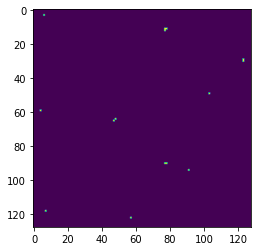

preds: (15, 4)
GT boxes: (29, 4)


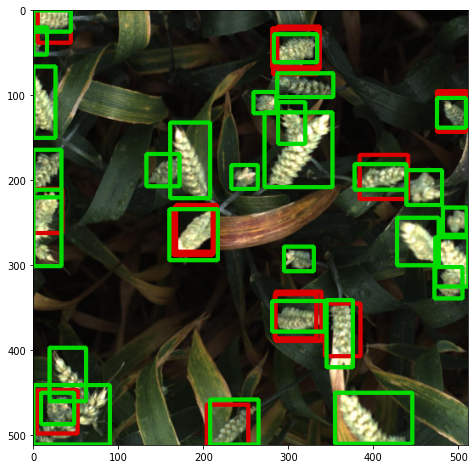

In [ ]:
for id in range(2):
    img, hm_gt, regr_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, regr = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id+".jpg"))
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = pool(hm)
    plt.imshow(hm>0.6)
    plt.show()
    sample = showbox(img, hm, regr, 0.6)
    
    # show gt
    sample = showgtbox(sample, hm_gt, regr_gt, 0.99)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.show()

##9) DETR

In [ ]:
!git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 260 (delta 0), reused 2 (delta 0), pack-reused 257
Receiving objects: 100% (260/260), 12.85 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 6.8 MB/s 
     |████████████████████████████████| 47.8 MB 1.1 MB/s 
albumentations==1.1.0 is successfully installed


In [ ]:
pip install opencv-python-headless==4.1.2.30

In [ ]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion


#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 5

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

In [ ]:
marking = pd.read_csv('../data/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [ ]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      
                      A.Resize(height=512, width=512, p=1),
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64),
                      
                      ToTensorV2()],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2()], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [ ]:
DIR_TRAIN = '../data/global-wheat-detection/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

In [ ]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [ ]:
matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [ ]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [ ]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')

In [ ]:
run(fold=0)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


  0%|          | 0/338 [00:00<?, ?it/s]

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


  0%|          | 0/85 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 1.4366603606551356| VALID_LOSS 0.9987182820544523|
Best model found for Fold 0 in Epoch 1........Saving Model


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 1.0593476917969404| VALID_LOSS 0.9143344262067009|
Best model found for Fold 0 in Epoch 2........Saving Model


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.98998170720755| VALID_LOSS 0.8910882262622609|
Best model found for Fold 0 in Epoch 3........Saving Model


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.9924015743139933| VALID_LOSS 0.8451894914402681|
Best model found for Fold 0 in Epoch 4........Saving Model


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.9464912828961773| VALID_LOSS 0.8297462210935704|
Best model found for Fold 0 in Epoch 5........Saving Model


In [ ]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):
        
        if p >0.5:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


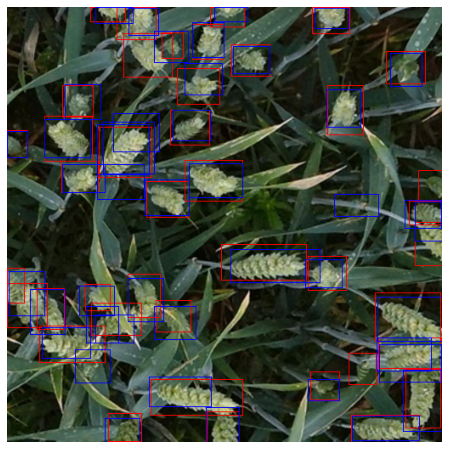

In [ ]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 0],model=model,device=torch.device('cuda'))